<a href="https://colab.research.google.com/github/pouyashojaei/datathon-code/blob/Pouya/WiDS_Texas_jayeon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WiDS hackathon

Jayeon Kim

In [181]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv2D
from tensorflow.keras import Model, Sequential

file_coast = 'coast_electricity_weather_history.csv'
file_north = 'north_electricity_weather_history.csv'
file_south = 'south_electricity_weather_history.csv'
file_east = 'east_electricity_weather_history.csv'
file_west = 'west_electricity_weather_history.csv'
file_far_west = 'far_west_electricity_weather_history.csv'

files = [file_north, file_south, file_east, file_coast, file_west, file_far_west]
dfs = [pd.read_csv(file, error_bad_lines=False) for file in files]

b'Skipping line 10538: expected 15 fields, saw 21\nSkipping line 21556: expected 15 fields, saw 16\nSkipping line 43192: expected 15 fields, saw 24\n'
b'Skipping line 75320: expected 15 fields, saw 21\n'


## Feature selection
### Part 1: Which features are correlated with which?
Now let us do some feature selection using the correlation matrix.

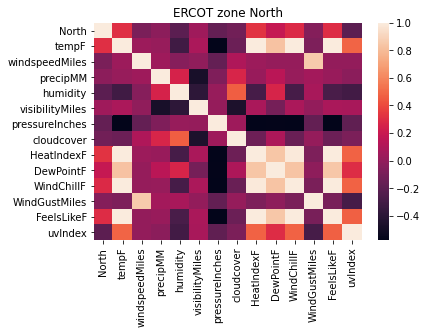

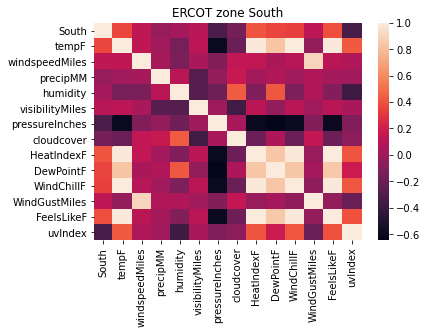

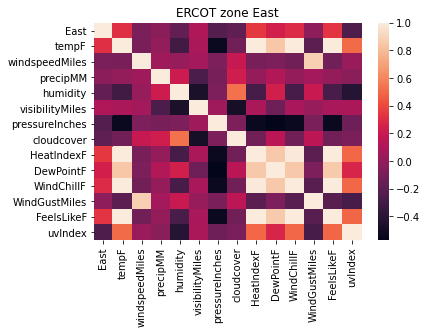

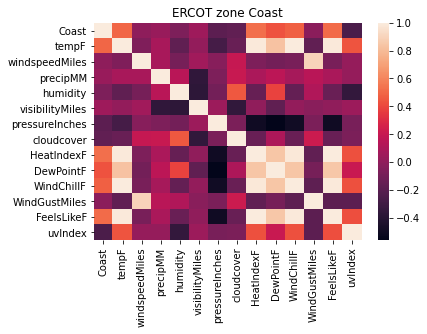

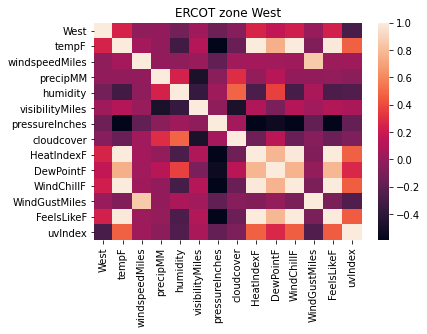

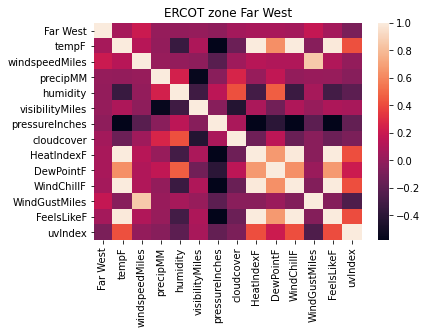

In [182]:
def view_heatmap(df):
  corr = df.corr()
  
  plt.figure()
  plt.title(f'ERCOT zone {df.columns[0]}')
  sns.heatmap(corr)
  plt.show()

for df in dfs:
  df.reset_index(inplace=True)
  df = df.drop(['level_0', 'index'], axis=1)
  
  view_heatmap(df)

Looking at the heatmaps for three ERCOT zones, we see that the correlation of predictor features and the target feature is not the same for every ERCOT zone. Generally, the correlation between the target feature and predictor features appears weaker in ERCOT zones located in the west. Perhaps this is because western Texas is less susceptible to extreme weather? (compared to coastal Texas that would see a lot of hurricanes). 

Generally, features with stronger correlation appear to be tempF, HeatIndexF, DewPointF, WindChillF and FeelsLikeF, whereas there appears to be a strong negative correlation between electricity demand and uvIndex. This is likely because electricity supply levels sharply decrease during nighttime (when UV levels are lower).

### Part 2: Check for low-variance features
I checked to see whether any low-variance features could be removed from the data.

In [200]:
def view_variance_threshold(df):
  X = pd.DataFrame(df.iloc[:,1:])
  y = pd.DataFrame(df.iloc[0])
  
  sel = VarianceThreshold(threshold=.5)
  sel.fit_transform(X)
  to_remove = X.columns[(np.where(sel.get_support() == False))]
  return list(to_remove)

for df in dfs:
  df = df.drop(['level_0', 'index'], axis=1)
  print(f'ERCOT weather zone: {df.columns[0]}')
  print(f'Low-variance feature(s): {view_variance_threshold(df)} \n')

ERCOT weather zone: North
Low-variance feature(s): ['pressureInches'] 

ERCOT weather zone: South
Low-variance feature(s): ['pressureInches'] 

ERCOT weather zone: East
Low-variance feature(s): ['pressureInches'] 

ERCOT weather zone: Coast
Low-variance feature(s): [] 

ERCOT weather zone: West
Low-variance feature(s): ['pressureInches'] 

ERCOT weather zone: Far West
Low-variance feature(s): ['pressureInches'] 



For most ERCOT weather zones, pressureInches is a low-variance feature, so the feature will be removed from the data before modelling.

## Modelling

In [205]:
def split_data(df):
  n_rows, n_cols = df.shape

  train = df.iloc[:n_rows-668]
  test = df.iloc[-668:] #is the size important?

  min_max_scaler = MinMaxScaler(feature_range=(0,1))
  train_scaled = min_max_scaler.fit_transform(train)
  train_scaled = pd.DataFrame(train_scaled)

  X_train = pd.DataFrame(train_scaled.iloc[:, 1:])
  y_train = pd.DataFrame(train_scaled.iloc[:, 0])
  X_train.columns = train.columns[1:] #put back the column names
  y_train.columns = train.columns[:1]

  test_scaled = min_max_scaler.fit_transform(test)
  test_scaled = pd.DataFrame(test_scaled)

  X_test = pd.DataFrame(test_scaled.iloc[:, 1:])
  y_test = pd.DataFrame(test_scaled.iloc[:, 0])
  X_test.columns = test.columns[1:]
  y_test.columns = test.columns[:1]

  return X_train, y_train, X_test, y_test

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])

    return np.array(Xs), np.array(ys)

def test_time_steps(X_train, y_train, X_test, y_test, t=24):
  X_train_steps, y_train_steps = create_dataset(X_train, y_train, t)
  X_test_steps, y_test_steps = create_dataset(X_test, y_test, t)

  print(X_train_steps.shape)
  model = Sequential()
  model.add(LSTM(units=12,
                 input_shape=(X_train_steps.shape[1], X_train_steps.shape[2])))
  model.add(tf.keras.layers.Dense(units=2))
  model.compile(loss='mean_squared_error', 
                optimizer=tf.keras.optimizers.Adam(0.001))

  history = model.fit(
      X_train_steps[len(X_train_steps)-500:len(X_train_steps),:], 
      y_train_steps[len(y_train_steps)-500:len(y_train_steps)],
      epochs=3,
      batch_size=1,
      validation_split=0.1,
      verbose=1,
      shuffle=False)

  y_pred = model.predict(X_test_steps)

  n_rows = y_pred.shape[0]
  n_features = 13 #X_train_steps.shape[2] + 1 #X_train.shape[1] + 1

  # An array that is compatible to the original dataset on which the scaler was applied

  predicted_np = np.column_stack((y_pred, 
                                  np.ones((n_rows, n_features)) ))
  print(predicted_np.shape)
  predicted_inverse = min_max_scaler.inverse_transform(predicted_np)
  
  print('?')
  actual_np = np.column_stack((y_test_steps, 
                               np.ones((n_rows, n_features)) ))
  actual_inverse = min_max_scaler.inverse_transform(actual_np)

  plt.figure(figsize=(15,5))
  plt.plot(actual_inverse[:168:,0], color='green', label = 'Actual')
  plt.plot(predicted_inverse[:168,0], color='red', label = 'Predicted')
  plt.title(f'Electricity consumption for 168 hours')
  plt.xlabel('Time')
  plt.ylabel('Electricity consumption')
  plt.legend()
  plt.show()

for df in dfs:
  df = df.drop(['level_0', 'index'], axis=1)
  print(f'ERCOT weather region {df.columns[0]}')
  to_drop = view_variance_threshold(df)
  df = df.drop(to_drop, axis=1)
  print(df.shape)
  
  X_train, y_train, X_test, y_test = split_data(df)
  test_time_steps(X_train, y_train, X_test, y_test, t=168)

ERCOT weather region North
(113218, 13)
(112382, 168, 12)
Epoch 1/3
450/450 [==============================] - 15s 30ms/step - loss: 0.0051 - val_loss: 0.0072
Epoch 2/3
450/450 [==============================] - 13s 29ms/step - loss: 0.0021 - val_loss: 0.0069
Epoch 3/3
450/450 [==============================] - 13s 30ms/step - loss: 0.0017 - val_loss: 0.0069
(500, 15)


ValueError: ignored